# ProdLDA implementation on newsgroup dataset

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
import torch
import pandas as pd
import numpy as np

import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

from zzz_utils import *
from prod_lda import *

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1)

## Loading and process the data

In [14]:
news = fetch_20newsgroups(subset='all')
vectorizer = CountVectorizer(max_df=0.5, min_df=30, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['id'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

/Users/ckapoura/miniconda3/envs/stm/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 9374
Corpus size: torch.Size([18846, 9374])


## Testing variational inference

In [4]:
pyro.clear_param_store()
nTopics = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
docs = docs.float().to(device)
obj = fit_prod_lda(D = docs, nTopics = nTopics, nEpochs = 20, batch_size=32, lr = 0.01, seed = 123)

  1550829 ----------------------------------------
  1550829 Fitting 18846 cells
  1550836 Step	Loss
  1559300     0	392237.8020365397
  1568426     1	374521.1013041178
  1577227     2	369815.4358723958
  1586011     3	371311.6291687012
  1594668     4	368547.5662618001
  1603541     5	366953.32239379885
  1612442     6	364734.39785970055
  1621648     7	361614.790818278
  1630950     8	361077.83763020835
  1641288     9	359996.83036905923
  1657357    10	362883.0179300944
  1675889    11	362571.2293233236
  1689077    12	360588.3036743164
  1700024    13	360305.8377380371
  1709330    14	358426.0452758789
  1719021    15	359720.94596557616
  1728444    16	357117.3515360514
  1738420    17	357181.8994893392
  1747977    18	357689.0350748698
  1757334    19	358361.578519694
  1757335 final loss = 358361.578519694


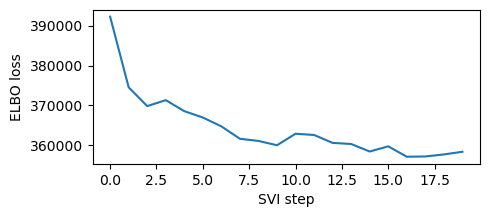

In [5]:
# plot ELBO losses
losses = obj['losses']

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.

In [6]:
# Get the fitted guide object, from which we will sample from.
guide = obj['prodLDA'].guide

In [8]:
# A single sample from the guide
post_sample = guide(D = docs)

In [12]:
post_sample[1:10, :] # posterior theta

tensor([[3.6113e-01, 3.5518e-02, 1.0181e-01, 6.4907e-02, 4.7332e-02, 2.3484e-01,
         6.3064e-03, 2.5074e-03, 3.9699e-02, 1.0595e-01],
        [4.5654e-02, 3.1257e-02, 1.2180e-01, 1.0838e-02, 2.0106e-02, 7.1144e-04,
         7.4194e-02, 5.8490e-01, 1.0131e-01, 9.2294e-03],
        [8.9144e-01, 1.0913e-02, 2.8780e-03, 9.2196e-05, 9.1862e-04, 1.1854e-02,
         4.5707e-02, 3.5308e-04, 9.1789e-03, 2.6664e-02],
        [1.7659e-01, 9.4375e-03, 7.0697e-03, 5.9721e-01, 3.2062e-02, 1.7366e-02,
         9.3751e-03, 3.8924e-03, 3.9509e-02, 1.0748e-01],
        [8.8641e-02, 7.5979e-02, 4.4014e-02, 3.2781e-01, 2.0058e-02, 4.4116e-02,
         1.9153e-01, 4.6227e-02, 7.9616e-02, 8.2004e-02],
        [6.2547e-03, 4.1536e-02, 3.0263e-01, 2.1401e-01, 7.0918e-02, 7.5992e-02,
         6.8213e-02, 1.5447e-01, 3.7114e-02, 2.8863e-02],
        [5.1797e-03, 3.2603e-02, 4.1108e-02, 1.0630e-02, 1.9285e-01, 3.5597e-02,
         1.9951e-02, 7.1303e-02, 1.7064e-02, 5.7372e-01],
        [1.5827e-02, 7.9968

### WordClouds

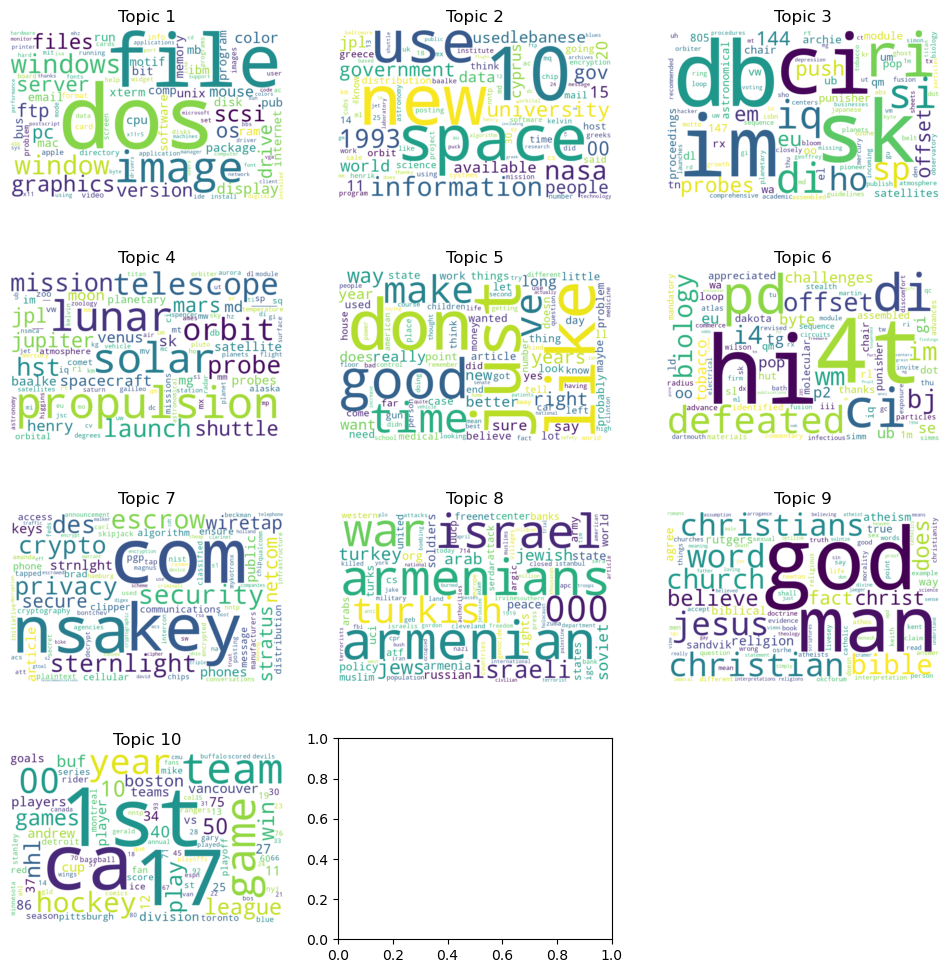

In [15]:
prodLDA = obj['prodLDA']
phi = prodLDA.get_phi()
fig, axs = plt.subplots(4, 3, figsize=(12, 12))
for n in range(phi.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(scale_zero_one(phi[n]), vocab, axs[i, j], 'Topic %d' % (n + 1))
axs[-1, -1].axis('off');

plt.show()